## Creating Murmuration Plots for Glacial Data

This notebook lays out the details of how we use [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/) to calculate correlation between our speleothem oxygen isotope data and insolation at various latitudes, and how we construct "murmuration" plots from this data. These are identical to those built in the `Leviathan Cave and Insolation` notebook, only now the records have been subdivided into glacial/interglacial components. Structurally this notebook is also nearly identical to `Interglacial Correlation Analysis`, we just focus on Glacial periods here.

The notebook is structured as follows:

1. Define a function that will be used to calculate correlations between records that contain large hiatuses (as has been defined elsewhere in this book)
2. Define insolation curves using [climlab](https://climlab.readthedocs.io/en/latest/)
3. Create versions of each of our records that are comprised only of data from glacial periods
4. Calculate correlation between insolation at various latitudes and the glacial records
5. Plot results

In [1]:
import pickle

from tqdm import tqdm

import pyleoclim as pyleo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

Tokenization took: 1.16 ms
Type conversion took: 0.73 ms
Parser memory cleanup took: 0.00 ms


Defining our correlation function, see `Leviathan Cave and Insolation` notebook for discussion:

In [2]:
def correlate_hiatus_series(series1, series2, cutoff_scale1=None):
    '''Function to correlate series with large gaps. This is done by segmenting the time series, smoothing (if this is desired),
    and then reconnecting the time series with a dummy time axis so as not to re-introduce the hiatuses.
    
    series1 : pyleoclim.Series
        One series to correlate, presumed to have hiatuses
    series2 : pyleoclim.Series
        Other series to correlate, presumed to not have hiatuses
    cutoff_scale : int
        Cutoff scale for smoothing for series 1
        '''
    
    if cutoff_scale1:
        segments = series1.segment()
        if isinstance(segments,pyleo.core.multiplegeoseries.MultipleGeoSeries):
            smoothed_series_value = []
            smoothed_series_time = []
            for segment in segments.series_list:
                if max(segment.time)-min(segment.time) > 6:
                    segment_smooth = segment.interp().filter(cutoff_scale=cutoff_scale1)
                    smoothed_series_value.extend(segment_smooth.value)
                    smoothed_series_time.extend(segment_smooth.time)
            smoothed_series = series1.copy()
            smoothed_series.value = smoothed_series_value
            smoothed_series.time = smoothed_series_time
        else:
            smoothed_series = series1.interp().filter(cutoff_scale=cutoff_scale1)
        series1 = smoothed_series

    smoothed_segments = series1.segment()
    series1_values = []
    series2_values = []
    if isinstance(smoothed_segments,pyleo.core.multiplegeoseries.MultipleGeoSeries):
        for segment in smoothed_segments.series_list:
            ms = pyleo.MultipleSeries([segment,series2]).common_time()
            s1,s2 = ms.series_list
            series1_values.extend(s1.value)
            series2_values.extend(s2.value)
        assert len(series1_values) == len(series2_values)
        time = np.arange(len(series1_values))
        s1_corr = pyleo.Series(time=np.array(time),value=np.array(series1_values),verbose=False)
        s2_corr = pyleo.Series(time=np.array(time),value=np.array(series2_values),verbose=False)
    else:
        s1_corr = series1
        s2_corr = series2

    #Normally this isn't necessary, just dealing with a bug in the pyleoclim library
    s1_corr.time = np.array(s1_corr.time)
    s1_corr.value = np.array(s1_corr.value)
    s2_corr.time = np.array(s2_corr.time)
    s2_corr.value = np.array(s2_corr.value)
    
    corr = s1_corr.correlation(s2_corr,number=1,mute_pbar=True)

    return corr

Creating integrated insolation curve at northern hemisphere latitudes and southern hemisphere latitudes over the respective summer months:

In [3]:
# Creating insolation dictionaries

lat_list = np.arange(-80,85,5)
jja_dict = {}
djf_dict = {}

# array with specified kyears (can be plain numpy or xarray.DataArray)
years = np.arange(-1000, 1)

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=years)

#Day numbers from June 1st to August 31st
jja_days = np.arange(152,243)

#Day numbers from December 1st to January 31st
djf_days1 = np.arange(335,365)
djf_days2 = np.arange(0,60)
djf_days = np.concatenate((djf_days1,djf_days2))

for lat in lat_list:
    if lat > 0:
        days = jja_days
        inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim='day')
        inso_series = pyleo.Series(time=0-years[::-1],value=inso[::-1],time_name='Age',time_unit='Kyr BP',value_name=f'JJA Insolation {lat} N',value_unit='W/m^2',verbose=False)
        jja_dict[lat] = inso_series
    elif lat < 0:
        days = djf_days
        inso = daily_insolation(lat=lat, day=days, orb=orb).mean(dim='day')
        inso_series = pyleo.Series(time=0-years[::-1],value=inso[::-1],time_name='Age',time_unit='Kyr BP',value_name=f'DJF Insolation {-lat} S',value_unit='W/m^2',verbose=False)
        djf_dict[lat] = inso_series
    else:
        continue

Defining MIS boundaries:

In [4]:
# MIS boundaries

MIS_df = pd.read_table('https://lorraine-lisiecki.com/LR04_MISboundaries.txt',skiprows=1,header=0,delim_whitespace=True,nrows=25,index_col='Boundary') 

interglacial_to_glacial = ['1/2','5/6','7/8','9/10','11/12','13/14','15/16','17/18','19/20']
glacial_to_interglacial = ['4/5','6/7','8/9','10/11','12/13','14/15','16/17','18/19']

glacial_timing = [(MIS_df.loc[interglacial_to_glacial[idx]]['Age(ka)'],MIS_df.loc[glacial_to_interglacial[idx]]['Age(ka)']) for idx in range(len(glacial_to_interglacial))]
interglacial_timing = [(glacial_timing[idx-1][1],glacial_timing[idx][0]) for idx in range(1,len(glacial_to_interglacial))]

In [5]:
# Loading data

with open('../../data/geo_ms_composite_dict.pkl','rb') as handle:
    geo_ms_composite_dict = pickle.load(handle)

with open('../../data/cmap_grouped.pkl','rb') as handle:
    cmap = pickle.load(handle)

Creating glacial series using previously defined MIS boundaries:

In [6]:
# Creating glacial series

glacial_dict = {}
glacial_lengths = {}

for label,series in geo_ms_composite_dict.items():
    glacial_lengths[label] = 0
    series = series.convert_time_unit('kyrs BP')
    value = []
    time = []
    for interval in glacial_timing:
        series_interval = series.slice(interval)
        if len(series_interval.time) > 1:
            value.extend(series_interval.value)
            time.extend(series_interval.time)
            length = max(series_interval.time)-min(series_interval.time)
            glacial_lengths[label] += length
    glacial_series = series.copy()
    glacial_series.time = time
    glacial_series.value = value
    glacial_dict[label] = glacial_series

Calculating correlation at various latitudes and with various amounts of shift in the oxygen isotope data:

In [7]:
# Correlating glacial series with insolation

shift_array = np.arange(0,6.1,.5) # Define the leads/lags to be analyzed in units of your time axis (we use kyrs BP here)
#shift_array = np.arange(-8,8.1,2)
series_shift_dict_glacial = {shift:{} for shift in shift_array}

for shift in tqdm(shift_array):
    for idx,orig_series in enumerate(glacial_dict.values()):
        series = orig_series.copy()
        label = series.label
        series.time += shift
        lat = series.lat

        corr_res = {}
        if lat > 0:
            for corr_lat,corr_series in jja_dict.items():
                corr = correlate_hiatus_series(series1=series,series2=corr_series,cutoff_scale1=6)
                corr_res[corr_lat] = [corr.p,corr.r]
        elif lat < 0:
            for corr_lat,corr_series in djf_dict.items():
                corr = correlate_hiatus_series(series1=series,series2=corr_series,cutoff_scale1=6)
                corr_res[corr_lat] = [corr.p,corr.r]

        correlated_inso = []

        for corr_lat,res in corr_res.items():
            corr_p,corr_r = res
            correlated_inso.append([corr_lat,corr_p,corr_r])

        series_shift_dict_glacial[shift][label] = correlated_inso

  0%|                                                                                            | 0/13 [00:00<?, ?it/s]

  8%|██████▍                                                                             | 1/13 [00:04<00:49,  4.14s/it]

 15%|████████████▉                                                                       | 2/13 [00:08<00:44,  4.08s/it]

 23%|███████████████████▍                                                                | 3/13 [00:12<00:40,  4.04s/it]

 31%|█████████████████████████▊                                                          | 4/13 [00:16<00:36,  4.06s/it]

 38%|████████████████████████████████▎                                                   | 5/13 [00:20<00:32,  4.09s/it]

 46%|██████████████████████████████████████▊                                             | 6/13 [00:24<00:28,  4.11s/it]

 54%|█████████████████████████████████████████████▏                                      | 7/13 [00:28<00:24,  4.14s/it]

 62%|███████████████████████████████████████████████████▋                                | 8/13 [00:32<00:20,  4.13s/it]

 69%|██████████████████████████████████████████████████████████▏                         | 9/13 [00:36<00:16,  4.13s/it]

 77%|███████████████████████████████████████████████████████████████▊                   | 10/13 [00:41<00:12,  4.15s/it]

 85%|██████████████████████████████████████████████████████████████████████▏            | 11/13 [00:45<00:08,  4.17s/it]

 92%|████████████████████████████████████████████████████████████████████████████▌      | 12/13 [00:49<00:04,  4.20s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.17s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.14s/it]

Loading into DataFrame for ease of plotting:

In [8]:
# Creating dataframes

series_df_dict_glacial = {}

for series in glacial_dict.values():
    columns = shift_array
    df = pd.DataFrame(index=np.arange(5,81,5),columns=columns)
    for shift in shift_array:
        corr_list = series_shift_dict_glacial[shift][series.label]
        for corr in corr_list:
            lat = np.abs(corr[0])
            r = corr[2]
            df.loc[lat,shift] = r**2
    series_df_dict_glacial[series.label] = df

Plotting:

Text(0.5, 1.05, 'R$^{2}$ vs. Latitude (Glacial)')

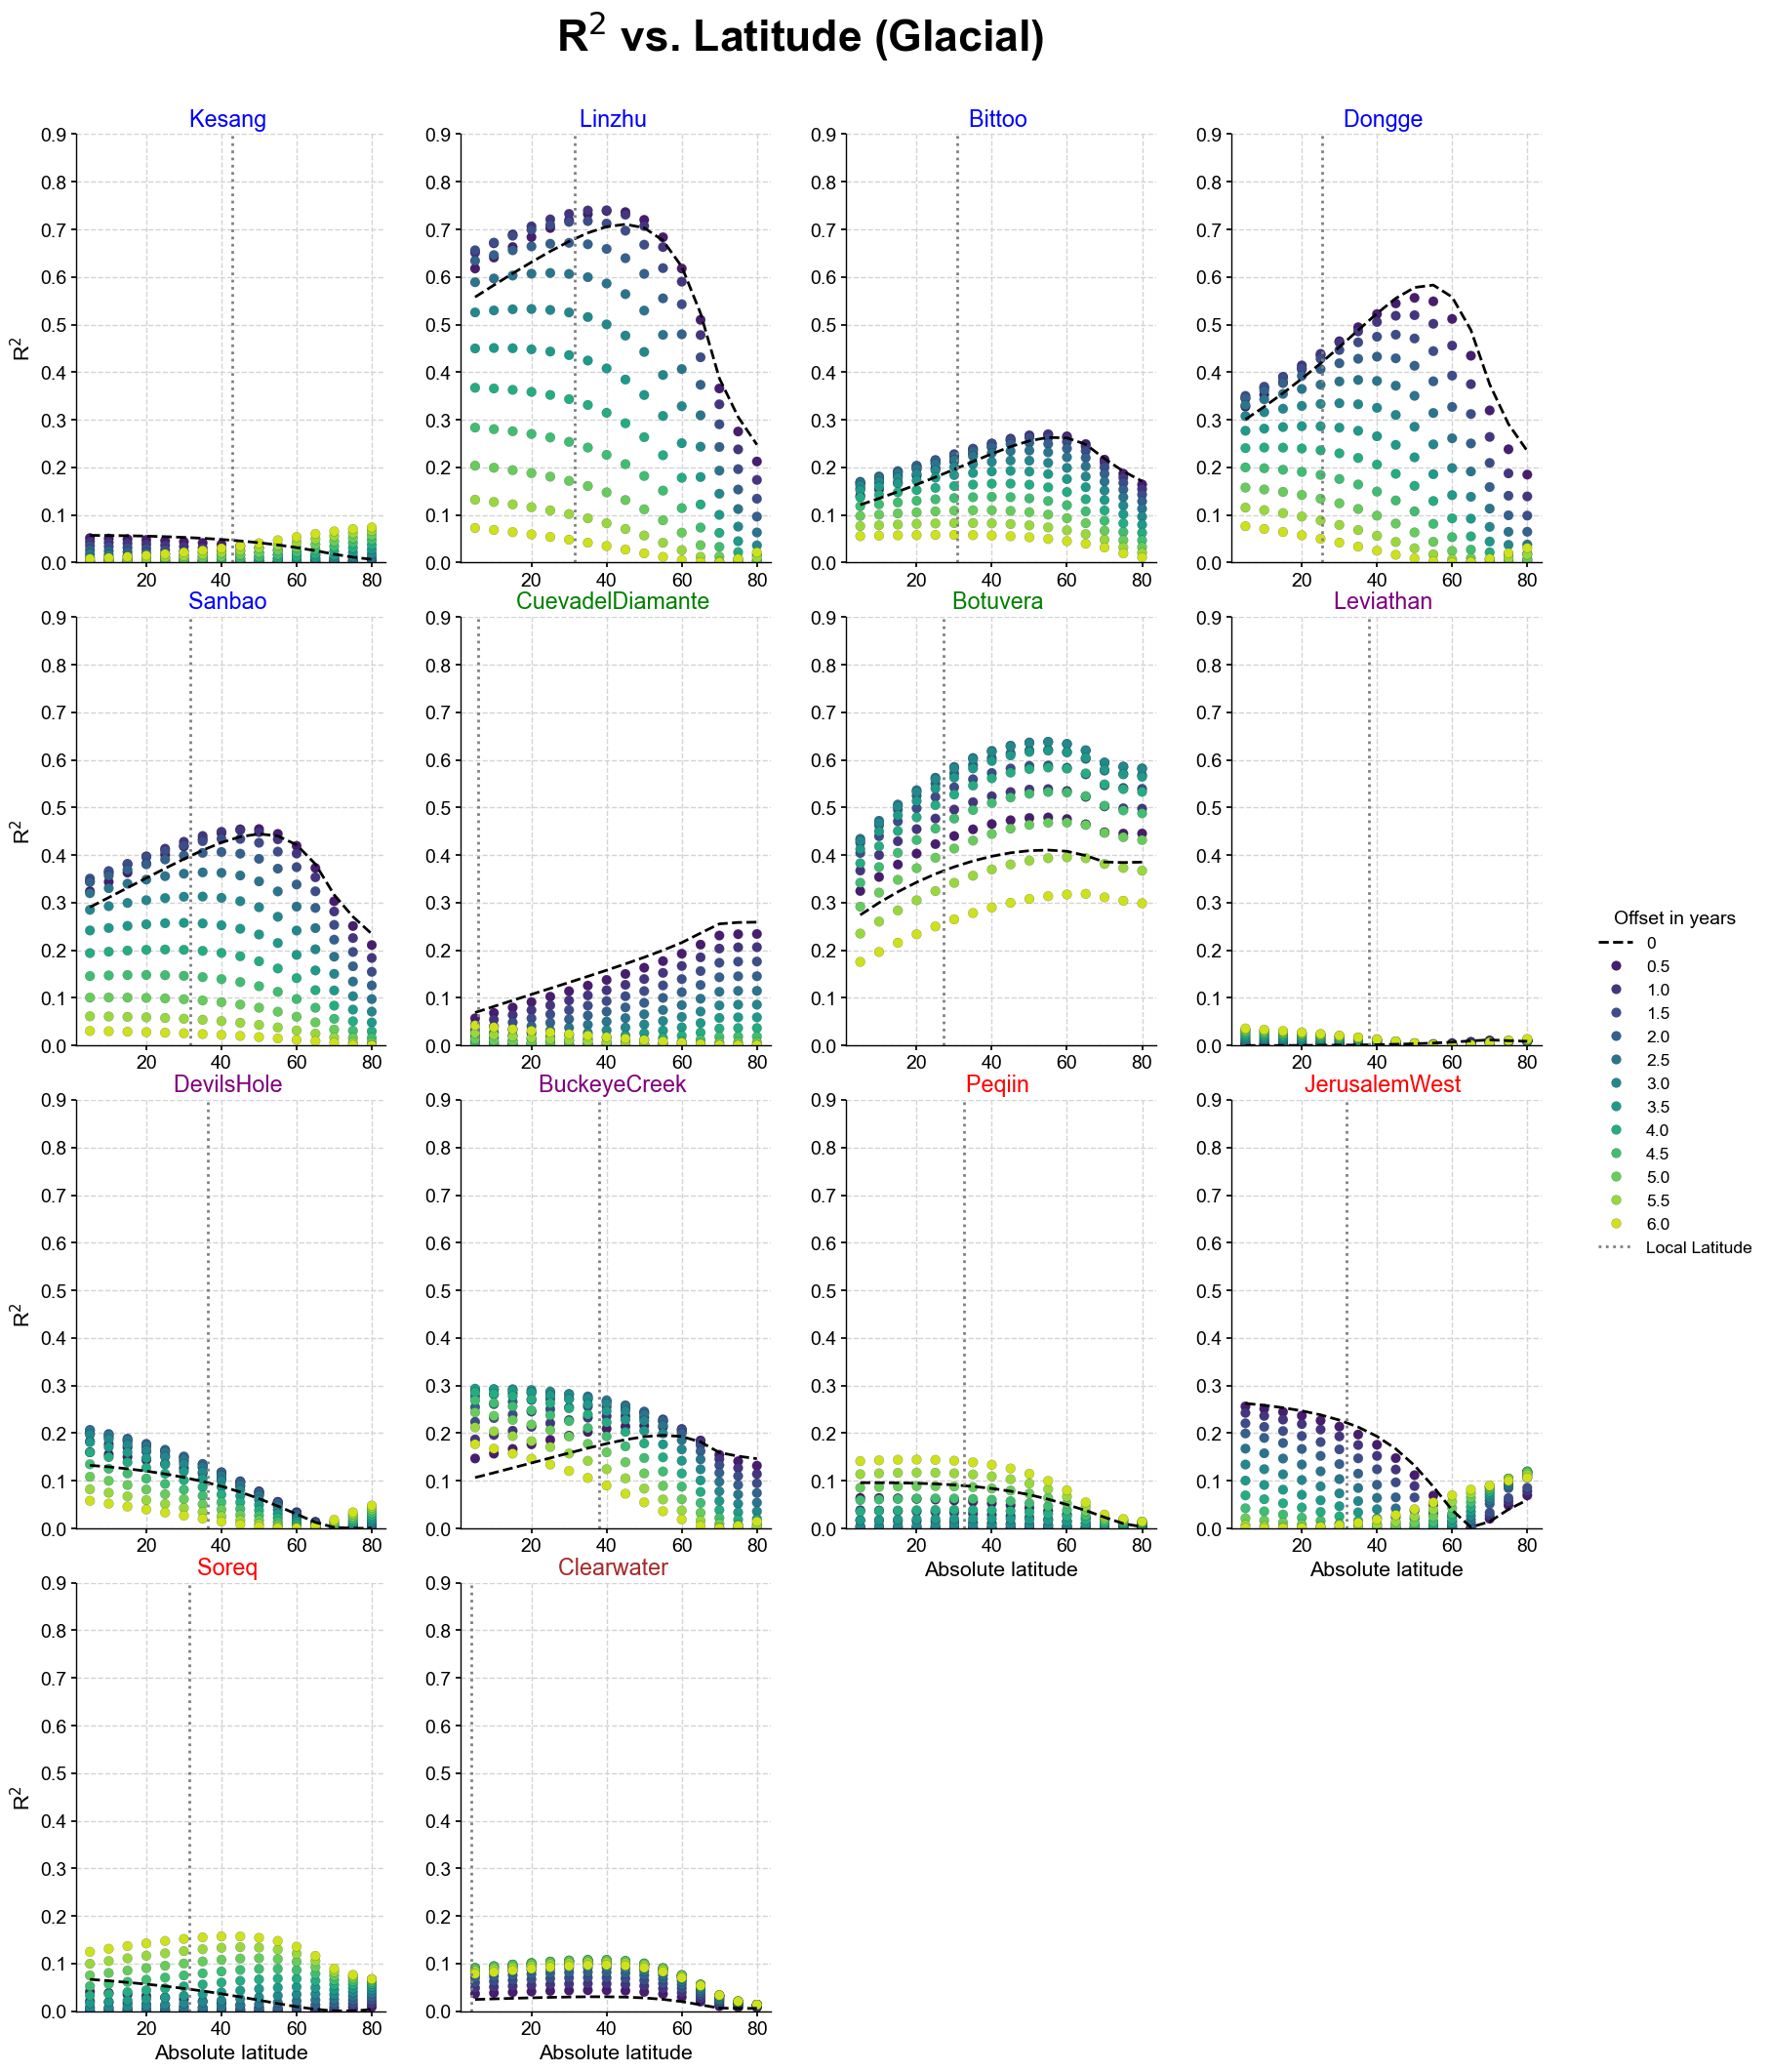

In [9]:
# Plotting

title_cmap = {
    'Kesang.China.2012': 'Blue',
    'Linzhu.China.2009': 'Blue',
    'Bittoo.India.2016': 'Blue',
    'Dongge.China.2004': 'Blue',
    'Sanbao.China.2016': 'Blue',
    'CuevadelDiamante.Peru.2013': 'Green',
    'Botuvera.Brazil.2005': 'Green',
    'Leviathan.Nevada.2017': 'Purple',
    'DevilsHole.Nevada.2017': 'Purple',
    'BuckeyeCreek.WestVirginia.2019': 'Purple',
    'Peqiin.Israel.2003': 'Red',
    'JerusalemWest.Jerusalem.1999': 'Red',
    'Soreq.Israel.2003': 'Red',
    'Clearwater.Borneo.2016': 'Brown'
}

fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(16,20))
#fig.subplots_adjust(wspace=0.6, hspace=0.4)
fig.tight_layout()

axes = ax.ravel()
colors = sns.color_palette('colorblind')

plot_order = [
    'Kesang.China.2012',
    'Linzhu.China.2009',
    'Bittoo.India.2016',
    'Dongge.China.2004',
    'Sanbao.China.2016',
    'CuevadelDiamante.Peru.2013',
    'Botuvera.Brazil.2005',
    'Leviathan.Nevada.2017',
    'DevilsHole.Nevada.2017',
    'BuckeyeCreek.WestVirginia.2019',
    'Peqiin.Israel.2003',
    'JerusalemWest.Jerusalem.1999',
    'Soreq.Israel.2003',
    'Clearwater.Borneo.2016',
]

for idx,label in enumerate(plot_order):

    df = series_df_dict_glacial[label]
    scatter_df = df.drop(labels=0,axis=1)
    sns.lineplot(x=df[0].index.to_numpy(),y=df[0].to_numpy(),ax=axes[idx],linestyle='--',color='black',label=0)
    sns.scatterplot(scatter_df,ax=axes[idx],legend=True,palette='viridis',markers=['o' for _ in scatter_df.columns],s=50,edgecolor='black',linewidth=.1)
    
    series = geo_ms_composite_dict[label]
    lat = np.abs(series.lat)
    axes[idx].axvline(x=lat,color='grey',label='Local Latitude',linestyle=':')

    if idx == len(series_df_dict_glacial.keys())-1:
        handles, labels = axes[idx].get_legend_handles_labels()
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=[1.12, 0.5],title='Offset in years')

    if idx in [0,4,8,12]:
        axes[idx].set_ylabel('R$^{2}$')
    if idx in [10,11,12,13]:
        axes[idx].set_xlabel('Absolute latitude')

    axes[idx].get_legend().remove()
    axes[idx].set_title(f"{label.split('.')[0]} ",color=title_cmap[label])# + f"{glacial_lengths[label]:.1f} kyr")
    axes[idx].set_ylim([0,.9])

fig.delaxes(ax[3][2])
fig.delaxes(ax[3][3])
plt.suptitle('R$^{2}$ vs. Latitude (Glacial)',y=1.05,fontsize=32,fontweight='bold')